# LOFAR LBA NCP
In this example, we'll make an observation of the North Celestial Pole (NCP) using the Low Band Antennas (LBA) of the LOFAR radio telescope. I think the LOFAR EoR group often observe towards the NCP, so it's a good example to try. I couldn't easily find a LOFAR catalogue that covers the NCP however, so create a sky model using the WENSS and NVSS catalogues, to try and get realistic spectral indicies.

Then we'll decided the morphology of the WENSS cat isn't good enough, and we'll just use NVSS. But we'll leave all the cross-matching stuff in there cos it's a useful reference, and otherwise I wasted my time writing it.

## Sky model WENSS x NVSS
The [WENSS](https://aas.aanda.org/articles/aas/abs/1997/11/ds1236/ds1236.html) catalogue is a 325 MHz survey of the NCP, so sits at a frequency close to where the LBA operates. It's relatively low resolution compared to what LBA is capable of at 54 arcsecs, but that will make the example simulation less computationally intensive which is sweet. We want to include spectra indicies if we can, so we'll cross-match it to the prolific [NVSS](https://iopscience.iop.org/article/10.1086/300337) catalogue (NVSS paper has a whopping 5000+ citations). NVSS is at 1.4 GHz, and we'll just assume everything is a power law between the two frequencies.

Using the postage stamp server [SkyView][https://skyview.gsfc.nasa.gov/current/cgi/query.pl], I've downloaded a WENSS image of the NCP at 325 MHz. This is what we want to try and emulate:


0.0029296875


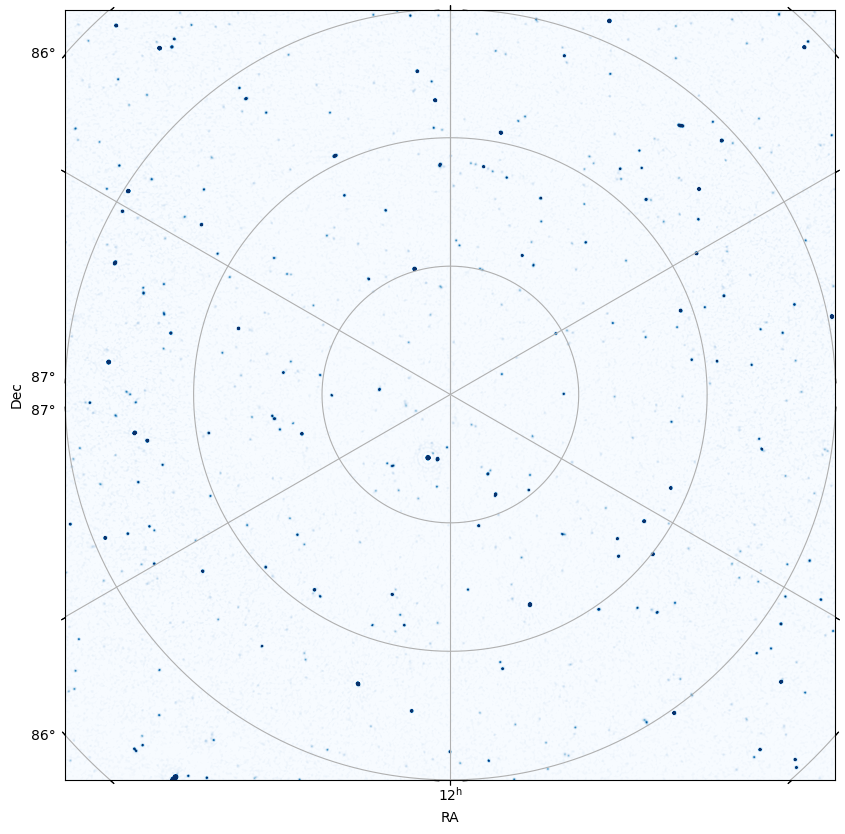

In [195]:
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt

with fits.open('wenss_sky.fits') as hdu:
    data_wenss = hdu[0].data
    header_wenss = hdu[0].header
    wcs_wenss = WCS(hdu[0].header)
    img_reso = hdu[0].header['CDELT2']
    print(img_reso)
    
fig, axs = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': wcs_wenss})
axs.imshow(data_wenss, origin='lower', cmap='Blues', vmin=0, vmax=0.1)
axs.grid()
axs.set_xlabel('RA')
axs.set_ylabel('Dec')
plt.show()

I've downloaded the two catalogues from [VizieR](https://vizier.cds.unistra.fr/). The first thing I'll do is crop them to a 3 degree radius around the NCP.

In [13]:
from astropy.table import Table

def crop_table(name):
    table = Table.read(name)
    decs = table['_DEJ2000']
    
    crop_table = table[decs > 87.0]
    crop_table.write(name.replace('.fits', '_crop.fits'), overwrite=True)
    
    return crop_table
    
crop_wenss = crop_table('vizier_wenss.fits')
crop_nvss = crop_table('vizier_nvss.fits')

print(len(crop_wenss), len(crop_nvss))
    

642 1272


OK, so we've ended up with 642 WENSS sources. Let's cross match them with the NVSS sources. Normally I'd just use [TOPCAT](https://www.star.bris.ac.uk/~mbt/topcat/) to do this graphically. Check out this [tutorial YouTube video](https://youtu.be/mdMtmy3Zq-Q&t=3582s) if you're unfamiliar. The video seems to have happened during the Covid-19 years, so if you lived through them you can have lovely flashbacks to endless online events. I'll use the `astropy` package to do this instead as I can do it in this notebook.

In [122]:
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np

ra_wenss = crop_wenss['_RAJ2000'].data
dec_wenss = crop_wenss['_DEJ2000'].data

ra_nvss = crop_nvss['_RAJ2000'].data
dec_nvss = crop_nvss['_DEJ2000'].data

coords_wenss = SkyCoord(ra=ra_wenss*u.degree, dec=dec_wenss*u.degree)
coords_nvss = SkyCoord(ra=ra_nvss*u.degree, dec=dec_nvss*u.degree)

nvss_indexes, d2d, d3d = coords_wenss.match_to_catalog_sky(coords_nvss)

OK, so `nvss_indexes` returns the indexes of NVSS sources that are the closest match to each WENSS source. `d2d` is the angular separation between the two sources, so if you want to chuck away anything that isnit nearby on the sky you can do that. Normally something like the resolution of the base catalogue you are matching to is a good start. This is why `TOPCAT` is sweet, because you can quickly try different values and plot them up quickly. Anyways, we'll just check that a) all of the cross-matches are unique, and b) none of the matches are too far away.

In [123]:
print("Number of WENSS sources: ", len(crop_wenss))
print("Number of unique matches: ", len(np.unique(nvss_indexes)))

Number of WENSS sources:  642
Number of unique matches:  603


Huh OK so we don't have matches to everything in WENSS. First thing to do is to discard any repeated matches. We'll just go for the closest match in the case of repeats.

In [124]:
##Sort everything by angular distance
argorder = np.argsort(d2d)
wenss_inds_sorted = argorder
nvss_inds_sorted = nvss_indexes[argorder]

nvss_match = np.empty(len(wenss_inds_sorted))
for wenss_ind, nvss_ind in zip(wenss_inds_sorted, nvss_inds_sorted):
    
    if nvss_ind in nvss_match:
        nvss_match[wenss_ind] = np.nan
    else:
        nvss_match[wenss_ind] = int(nvss_ind)

Let's plot up matches to see what's going on. We'll use a WCS so we can plot them up on the sky.

In [166]:
from astropy.wcs import WCS
from astropy.io import fits

# Define the FITS header template
header = fits.Header()

nside = 256
reso = 6 / nside

# Basic WCS parameters
header['NAXIS'] = 2                      # Number of axes
header['NAXIS1'] = nside                 # Reference pixel along X-axis
header['NAXIS2'] = nside                 # Reference pixel along Y-axis
header['CRPIX1'] = nside // 2            # Reference pixel along X-axis
header['CRPIX2'] = nside // 2            # Reference pixel along Y-axis
header['CRVAL1'] = 0.0                   # Reference RA (degrees)
header['CRVAL2'] = 90.0                  # Reference Dec (degrees)
header['CTYPE1'] = 'RA---SIN'            # RA projection type
header['CTYPE2'] = 'DEC--SIN'            # Dec projection type
header['CDELT1'] = -reso      # Pixel scale in RA (degrees/pixel)
header['CDELT2'] = reso       # Pixel scale in Dec (degrees/pixel)
header['CUNIT1'] = 'deg'                 # Units for RA
header['CUNIT2'] = 'deg'                 # Units for Dec

# Optionally, set the equinox and epoch
header['EQUINOX'] = 2000.0               # Equatorial coordinates J2000
header['RADESYS'] = 'ICRS'               # Coordinate reference system

# Create a WCS object from the header
wcs = WCS(header)

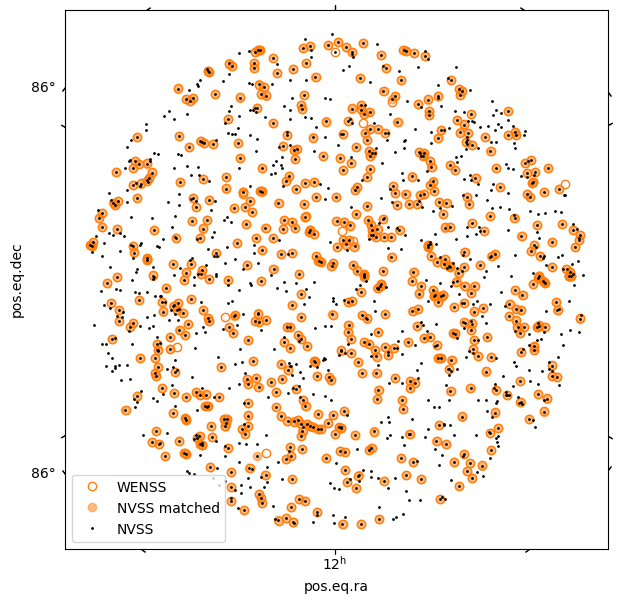

In [167]:
fig, axs = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': wcs})

nvss_match_without_nan = nvss_match[~np.isnan(nvss_match)].astype(int)

axs.plot(ra_wenss, dec_wenss, 'C1o', mfc='none', transform=axs.get_transform('world'), label='WENSS')
axs.plot(ra_nvss[nvss_match_without_nan], dec_nvss[nvss_match_without_nan], 'C1o', alpha=0.5,
         transform=axs.get_transform('world'), label='NVSS matched')


axs.plot(ra_nvss, dec_nvss, 'k.', ms=2, transform=axs.get_transform('world'), label='NVSS')

axs.legend()
plt.show()

Eh, we have a couple of places where two NVSS sources are close to a WENSS source, and just few instances where there is no match in NVSS. As this is just a simple example, we'll just use everything that has a match and call it good enough. If you were doing this for real, you could always use try and use (PUMA)[https://github.com/JLBLine/PUMA] to do a more sophisticated cross-match SHAMELESS PLUG OVER.

Right, let's take our matches and make a WODEN style sky model. First, grab all the relevant information, calculate spectral indices, check they look sensible.

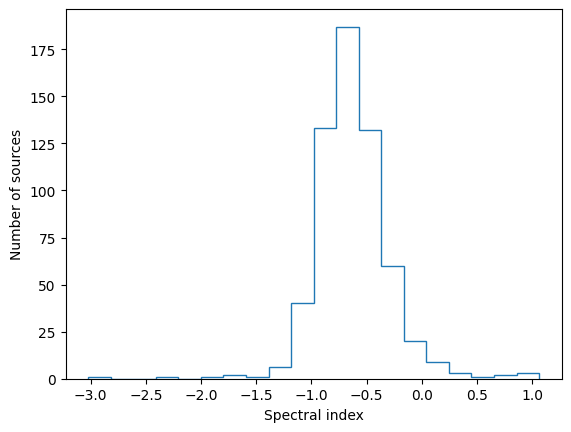

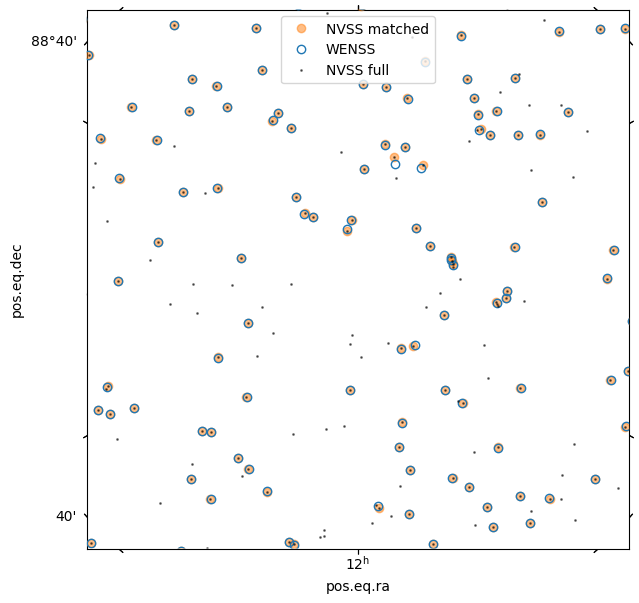

In [ ]:
from astropy.table import Column

##subsets we need
wenss_indexes = ~np.isnan(nvss_match)
use_nvss = nvss_match[~np.isnan(nvss_match)].astype(int)

# nvss_match_without_nan = nvss_match[~np.isnan(nvss_match)].astype(int)

unq_source_ids = np.array(crop_wenss['Name'][wenss_indexes], dtype='U32')
##order everything by source name to make adding component names easier
ras_wenss = crop_wenss['_RAJ2000'][wenss_indexes].data
decs_wenss = crop_wenss['_DEJ2000'][wenss_indexes].data
fluxes_330 = crop_wenss['Sint'][wenss_indexes].data/1000.0


ras_nvss = crop_nvss['_RAJ2000'][use_nvss].data
decs_nvss = crop_nvss['_DEJ2000'][use_nvss].data
ras_nvss_full = crop_nvss['_RAJ2000'].data
decs_nvss_full = crop_nvss['_DEJ2000'].data

##use the gaussians from NVSS as it has better resolution
fluxes_1400 = crop_nvss['S1_4'][use_nvss].data/1000.0
majors = crop_nvss['MajAxis'][use_nvss].data/3600.0
minors = crop_nvss['MinAxis'][use_nvss].data/3600.0
pas = np.array(crop_nvss['PA'][use_nvss], dtype=np.float64)

pas[np.isnan(pas)] = 0.0

alphas = np.log10(fluxes_1400/fluxes_330)/np.log10(1400.0/330.0)
##WODEN references all power law fluxes to 200MHz
fluxes_extrap = fluxes_330*(200.0/330.0)**alphas

plt.hist(alphas, bins=20, histtype='step')
plt.xlabel('Spectral index')
plt.ylabel('Number of sources')
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': wcs})
axs.plot(ras_nvss, decs_nvss, 'C1o', alpha=0.5, transform=axs.get_transform('world'), label='NVSS matched')
axs.plot(ras_wenss, decs_wenss, 'C0o', mfc='none', transform=axs.get_transform('world'), label='WENSS')
axs.plot(ras_nvss_full, decs_nvss_full, 'k.', ms=2, alpha=0.5, transform=axs.get_transform('world'), label='NVSS full')

edge = 60

axs.set_xlim(nside//2-edge, nside//2+edge)
axs.set_ylim(nside//2-edge, nside//2+edge)

axs.legend()

plt.show()


Yeah looks like we have a couple of mismatches but the histogram of the spectral index is good enough. Let's just crack on.

In [ ]:
num_comps = len(unq_source_ids)

unq_source_id_col = Column(unq_source_ids, name='UNQ_SOURCE_ID')

names = np.array([name+'_C000' for name in unq_source_ids], dtype='U32')
names_col = Column(names, name='NAME')

ras_col = Column(ras_wenss, name='RA', unit='deg')
decs_col = Column(decs_wenss, name='DEC', unit='deg')
fluxes_col = Column(fluxes_extrap, name='NORM_COMP_PL', unit='Jy')
si_col = Column(alphas, name='ALPHA_PL', unit='Jy')
majors_col = Column(majors, name='MAJOR_DC', unit='deg')
minors_col = Column(minors, name='MINOR_DC', unit='deg')
pas_col = Column(pas, name='PA_DC', unit='deg')

##Anything that has a major axis is a Gaussian, other make it a point source
comp_types = np.empty(unq_source_ids.shape, dtype='U3')
comp_types[majors == 0.0] = 'P'
comp_types[majors != 0.0] = 'G'

comp_types_col = Column(comp_types, name='COMP_TYPE')
##We're inputting everything as a power law
mod_types_col = Column(np.full(num_comps, 'pl'), name='MOD_TYPE')

cols = [unq_source_id_col, names_col,
        ras_col, decs_col, comp_types_col, mod_types_col,
        fluxes_col, si_col,
        majors_col, minors_col, pas_col]

new_table = Table(cols)
new_table.write('srclist_wenss_x_nvss.fits', overwrite=True)

<class 'numpy.ndarray'>


Finally, let's check out selected subset positions match the image we're trying to reproduce.

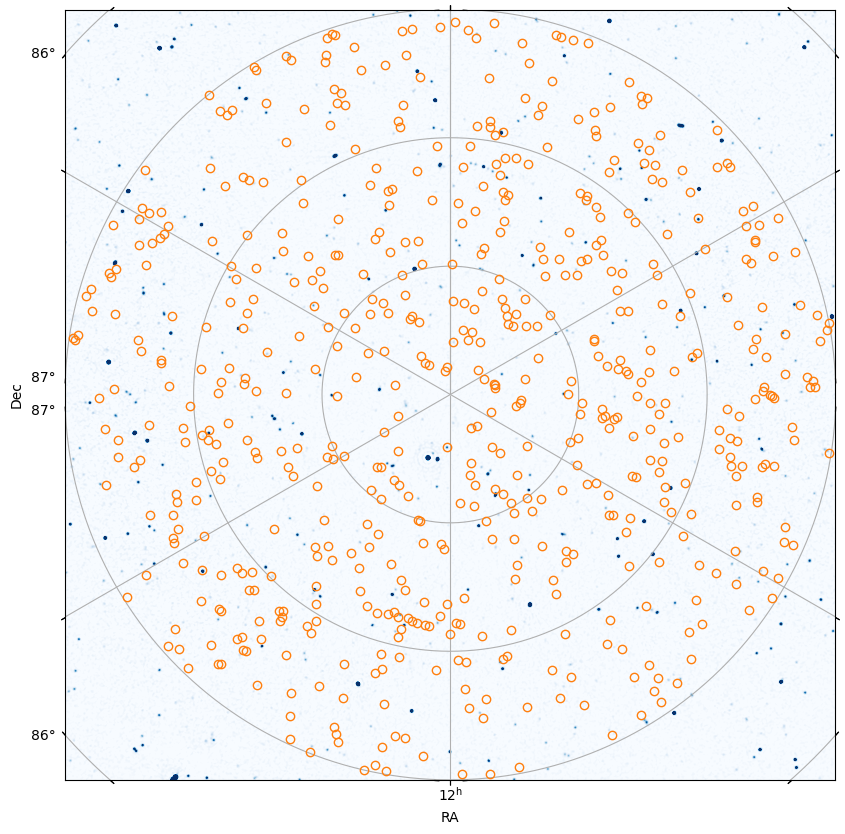

In [170]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': wcs_wenss})

axs.imshow(data_wenss, origin='lower', cmap='Blues', vmin=0, vmax=0.1)

axs.plot(ras_wenss, decs_wenss, 'C1o', mfc='none', transform=axs.get_transform('world'), label='WENSS')

axs.grid()
axs.set_xlabel('RA')
axs.set_ylabel('Dec')
plt.show()



Eh, what's this? All of our positions are messed up! Time for an aside on plotting things centred on the NCP.

## Plotting simulations centred at the NCP
Long story short, images centred at the NCP tend to render "upside down". I'm going to do this from a fresh simulation and image it, so you can also run it and convince yourself. I'm going to use `OSKAR` in the following, to try and convince you this isn't a `WODEN` bug. We're just going to run a simulation centred at NCP, and check source positions. I should not this problem *only happens at the NCP*; everywhere else on the sky, the positions come out perfectly.

We'll copy the OSKAR MWA telescope layout created using `test_installation/everybeam/create_OSKAR-MWA_ms/make_oskar-mwa_beam.ipynb` to run `OSKAR`.

In [33]:
cp -r ../../test_installation/everybeam/create_OSKAR-MWA_ms/MWA_phase1/ .

We'll need to move the array location to be able to see the NCP though. Might as well chuck it at the North pole.

In [35]:
with open('MWA_phase1/position.txt', 'w') as outfile:
    outfile.write('0.0 90 0.0\n')

Next, we'll make sky model with a number of point sources, close to the NCP. We'll use those positions to test whether the WCS works with imaged simulations.

In [172]:
ras = [0.0, 90.0, 180.0, 270.0]
decs = [89.5, 89, 88.5, 88]

flux_I = 1
flux_Q = 0
flux_U = 0
flux_V = 0
ref_freq = 180e+6
SI = 0

with open('skymodel.osm', 'w') as outfile:
    for ra, dec in zip(ras, decs):
        outfile.write(f"{ra} {dec} {flux_I} {flux_Q} {flux_U} {flux_V} {ref_freq} {SI}\n")

Finally, we'll write an `OSKAR` .ini script to simulate the observation centered on the NCP. We'll use the sky model we just created.

In [47]:
with open('run_oskar_sim.ini', 'w') as outfile:
    outfile.write("[General]\n")
    outfile.write("app=oskar_sim_interferometer\n")
    outfile.write("[sky]\n")
    outfile.write("oskar_sky_model/file=skymodel.osm\n")
    outfile.write("[observation]\n")
    outfile.write("phase_centre_dec_deg=90.0\n")
    outfile.write("phase_centre_ra_deg=0.0\n")
    outfile.write("start_frequency_hz=1.8e+08\n")
    outfile.write("frequency_inc_hz=4.0e+04\n")
    outfile.write("start_time_utc=2024-07-21 20:13:00.0\n")
    outfile.write("length=2.0\n")
    outfile.write("[telescope]\n")
    outfile.write("input_directory=MWA_phase1\n")
    outfile.write("aperture_array/element_pattern/dipole_length_units=Metres\n")
    outfile.write("[interferometer]\n")
    outfile.write("channel_bandwidth_hz=40000.0\n")
    outfile.write("time_average_sec=2.0\n")
    outfile.write("ms_filename=OSKAR_NCP_obs.ms\n")


I then ran this on the command line as my local machine just has a container version of `OSKAR`.

In [48]:
%%bash
singularity exec --nv  /home/jline/software/OSKAR-2.8.3-Python3.sif \
    oskar_sim_interferometer run_oskar_sim.ini

W|                                                                   
W|== WARNING: No GPU capability available.
W|                                                                   
 |                                                                   
=|== Loaded settings file 'run_oskar_sim.ini'
 |                                                                   
 | + Simulator settings
 |   - Use double precision              : true
 |   - Use GPUs                          : true
 |   - CUDA device IDs to use            : all
 |   - Number of compute devices         : auto
 |   - Max. number of sources per chunk  : 16384
 | + Sky model settings
 |   - OSKAR sky model file settings
 |     * OSKAR sky model file(s)         : skymodel.osm
 | + Observation settings
 |   - Observation mode                  : Tracking
 |   - Phase centre RA [deg]             : 0.0
 |   - Phase centre Dec [deg]            : 90.0
 |   - Start frequency [Hz]              : 1.8e+08
 |   - Number of frequency

OK, now let's image things. Not actually going to bother cleaning as the dirty will be good enough here.

In [50]:
%%bash

###WARNING YOU PROBABLY DON'T NEED THIS ENV VARIABLE
###SOMETHING IS BORKED WITH MY WSCLEAN INSTALLATION
export OPENBLAS_NUM_THREADS=1

wsclean -name check_positions_NCP -size 256 256 -niter 0 \
  -auto-threshold 0.5 -auto-mask 3 \
  -pol I -multiscale -weight briggs 0 -scale 60asec -j 12 -mgain 0.85 \
  -no-update-model-required \
  OSKAR_NCP_obs.ms


WSClean version 3.0 (2021-08-26)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  180-180 (1)
Reordering OSKAR_NCP_obs.ms into 1 x 1 parts.
Reordering: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
Initializing model visibilities: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
 == Constructing image ==
Precalculating weights for Briggs'(0) weighting...
Opening reordered part 0 spw 0 for OSKAR_NCP_obs.ms
Detected 31.3 GB of system memory, usage not limited.
Opening reordered part 0 spw 0 for OSKAR_NCP_obs.ms
Determining min and max w & theoretical beam size... DONE (w=[0:5.41033] lambdas, maxuvw=1577.28 lambda)
Theoretic beam = 2.18'
Minimal inversion size: 283 x 283, using opti

OK, let's read in our image, plot it, and overplot where our WCS says our sources should be.

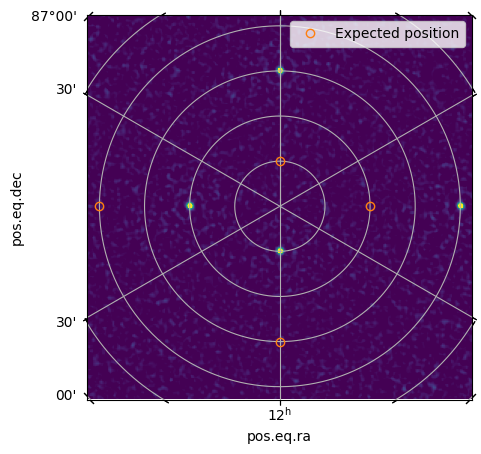

In [173]:
with fits.open('check_positions_NCP-dirty.fits') as hdul:
    
    ##Images out of WSClean have 4 axes, as there is a time and freq axes
    ##Hence we use squeeze and celestial here to make everything 2D
    data = np.squeeze(hdul[0].data)
    header = hdul[0].header
    wcs = WCS(header).celestial
    
    
fig, axs = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={'projection': wcs})
# fig, axs = plt.subplots(1, 1, figsize=(5, 5))

##Plot the data
axs.imshow(data, origin='lower', vmin=0, vmax=0.5)

##Now plot the sources as defined by the WCS
x, y = wcs.all_world2pix(ras, decs, 0)

axs.plot(x, y, 'C1o', mfc='none', label='Expected position')

axs.legend()

axs.grid()
plt.show()

OH NO, our sources aren't where they are supposed to be! This comes down to slightly opaque definition of RA origin when we're at the NCP. This isn't an imshow "origin=lower' mistake as well, as it turns out that is set automatically when you use the `wcs` in projection:

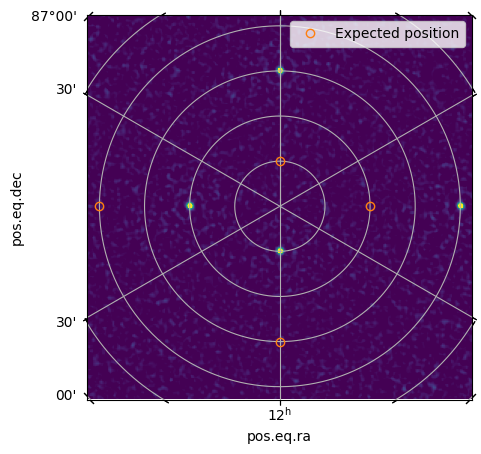

In [174]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={'projection': wcs})
axs.imshow(data, vmin=0, vmax=0.5)
axs.plot(x, y, 'C1o', mfc='none', label='Expected position')
axs.legend()
axs.grid()
plt.show()

If you open this via DS9 or CARTA, you see the same positional differences. If you open things with `kvis` however, you actually get the WCS loaded up differently. 

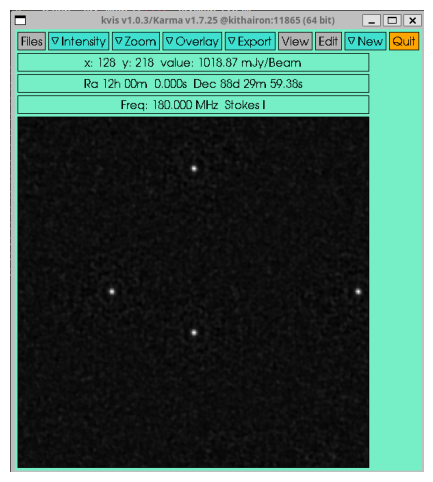

In [175]:
import matplotlib.image as mpimg
img = mpimg.imread('kvis_screenshot.png')
fig, axs = plt.subplots(1, 1, figsize=(6, 6))

axs.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

You can't see my mouse, but you can see that Ra,Dec = 12h, 88d30m corresponds to x, y = 128,218. This is not the same as was `astropy` reports:

In [63]:
x, y = wcs.all_world2pix(180, 88.5, 0)
print(int(x), int(y))

128 38


Essentially, the image out of the simulation comes out with RA=180 pointed to the top, whereas the WCS sticks 180 pointed down. Somehow, `kvis` knows to put RA=180 at the top. Some ancient wisdom there that has been lost to time.

ANYWAYS, to plot anything that comes out of `WODEN` or `OSKAR` from the NCP, imaged through `WSClean`, you have to make one edit to the WCS, and then everything is fine:

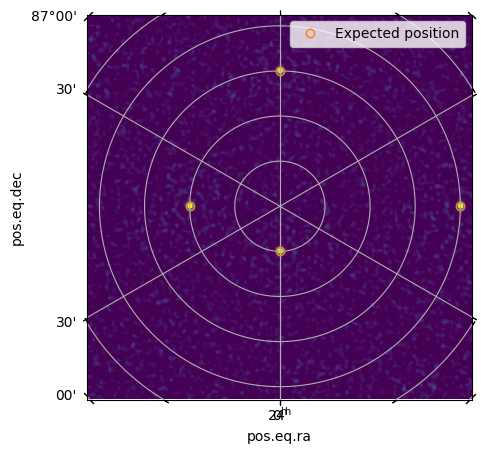

In [ ]:
from copy import deepcopy

header_edit = deepcopy(header)
# ##Just change this one thing
header_edit['CRVAL1'] = 180
wcs_edit = WCS(header_edit).celestial

x, y = wcs_edit.all_world2pix(ras, decs, 0)

fig, axs = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={'projection': wcs_edit})
axs.imshow(data, vmin=0, vmax=0.5)
axs.plot(x, y, 'C1o', mfc='none', label='Expected position')
axs.legend()
axs.grid()
plt.show()

So, you just need to change ['CRVAL1'] = 180, and then everything is fine. Dagnabbit.

## Run the simulation
After all that, let's check our sky model is legit by modifying our wcs and plotting our RA,Decs

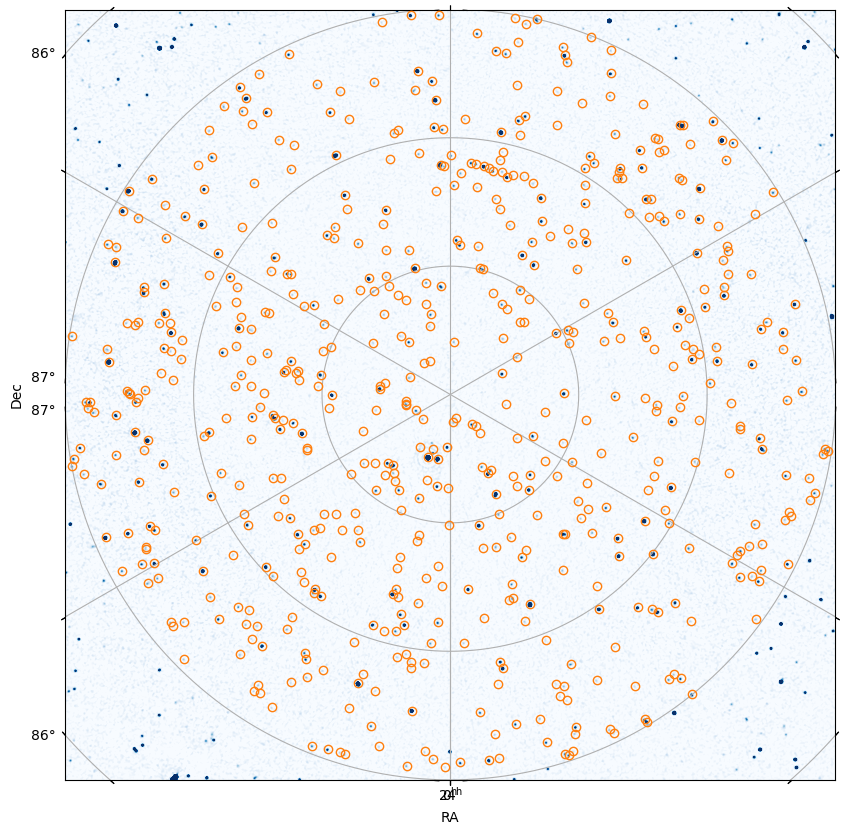

In [180]:
header_wenss_edit = deepcopy(header_wenss)
header_wenss_edit['CRVAL1'] = 180
wcs_wenss_edit = WCS(header_wenss_edit)


fig, axs = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': wcs_wenss_edit})

axs.imshow(data_wenss, origin='lower', cmap='Blues', vmin=0, vmax=0.05)

axs.plot(ras_wenss, decs_wenss, 'C1o', mfc='none', transform=axs.get_transform('world'), label='WENSS')

axs.grid()
axs.set_xlabel('RA')
axs.set_ylabel('Dec')
plt.show()



Ah, there go, source positions match up now. Let's run the simulation. Seeing as though this is the NCP, which is always visibile from LOFAR, we can do so mega $uv$-synthesis. We'll do a 24 hour obs, sampling once every hour. We'll do a 20MHz bandwidth, with 1MHz resoultion.

In [207]:
%%bash

primary_beam="everybeam_LOFAR"
ra0=0.0
dec0=90.0
lofar_lat=52.905329712
lofar_long=6.867996528
date="2014-10-16T17:01:36.000"
ms_path=../../test_installation/everybeam/lba.MS

uvfits_name=woden_LBA-NCP
cat_name=srclist_wenss_x_nvss.fits
    
freq_reso=1e+6
low_freq=75e+6
time_res=3600.0

num_freq_chans=20
num_time_steps=24

run_woden.py \
    --ra0=${ra0} \
    --dec0=${dec0} \
    --latitude=${lofar_lat} \
    --longitude=${lofar_long} \
    --date=${date} \
    --output_uvfits_prepend=${uvfits_name} \
    --cat_filename=${cat_name} \
    --primary_beam=${primary_beam} \
    --lowest_channel_freq=${low_freq} \
    --freq_res=${freq_reso} \
    --num_freq_channels=${num_freq_chans} \
    --band_nums=1 \
    --time_res=${time_res} \
    --num_time_steps=${num_time_steps} \
    --beam_ms_path=${ms_path}

/home/jline/software/anaconda3/envs/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.3.0')


Successful readonly open of default-locked table ../../test_installation/everybeam/lba.MS/ANTENNA: 10 columns, 37 rows
You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jline/software/WODEN_dev/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg 90.00000deg
Obs epoch initial LST was 294.9211333249 deg
Setting initial J2000 LST to 294.8284574349 deg
Setting initial mjd to 56946.7302777780
After precession initial latitude of the array is 52.8683555426 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 602 components
After cropping there are 602 components
From Set 0 thread num 0 reading 0 points, 76 gauss, 0 shape, 0 shape coeffs using thread id 0
From Set 0 thread num 1 reading 0 points, 76 gauss, 0 shape, 0 shape coeffs using thread id 1
From Set 0 thread nu

Let's see what `uv` coverage we got:

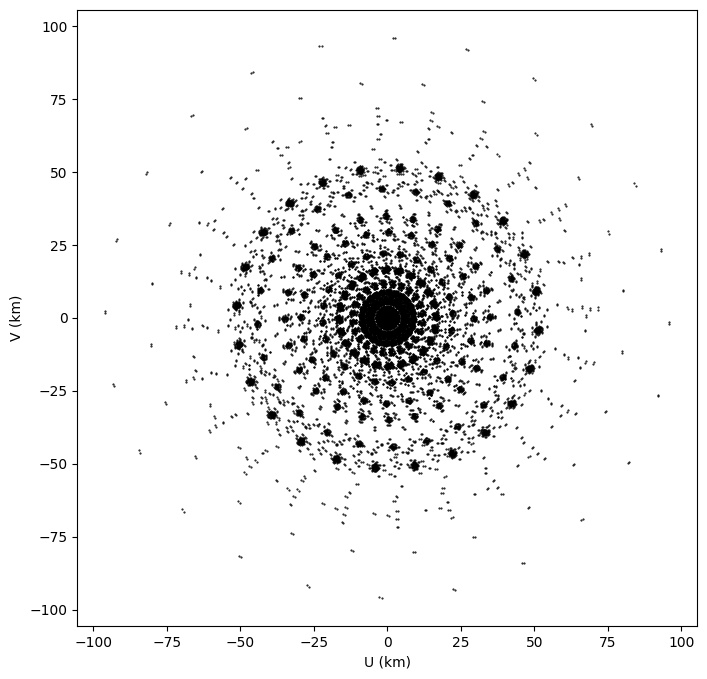

In [201]:
from astropy.constants import c
c = c.to('km/s').value

with fits.open('woden_LBA-NCP_band01.uvfits') as hdu:
    uu = (hdu[0].data['UU']*c)
    vv = (hdu[0].data['VV']*c)
    
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
axs.plot(uu, vv, 'k.', ms=1)
axs.plot(-uu, -vv, 'k.', ms=1)
axs.set_xlabel('U (km)')
axs.set_ylabel('V (km)')

plt.show()

ALL HAIL THE COSMIC EYE. Convert the UVFITS to an MS. Below is the function that's in `woden_uv2ms.py`. Just copied it here to show what's going on.

In [209]:
from pyuvdata import UVData
from subprocess import call
import os

def make_ms(uvfits_file, no_delete=False):
    """Takes a path to a uvfits file, checks it exists, and converts it to
    a measurement set of the same name at the same location"""

    ##If file exists, attempt to tranform it
    if os.path.isfile(uvfits_file):
        ##Get rid of '.uvfits' off the end of the file
        name = uvfits_file[:-7]
        ##Delete old measurement set if requested
        if no_delete:
            pass
        else:
            call("rm -r %s.ms" %name,shell=True)

        UV = UVData()
        UV.read(uvfits_file)
        
        UV.write_ms("{:s}.ms".format(name))
        
    else:
        ##print warning that uvfits file doesn't exist
        print("Could not find the uvfits specified by the path: "
              "\t{:s}. Skipping this tranformation".format(uvfits_file))
        

make_ms('woden_LBA-NCP_band01.uvfits')

The telescope frame is set to '????', which generally indicates ignorance. Defaulting the frame to 'itrs', but this may lead to other warnings or errors.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 191664.7410455463 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 191664.7410455463 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
Writing in the MS file that the units of the data are uncalib, although some CASA process will ignore this and assume the units are all in Jy (or may not know how to handle data in these units).


Righto, let's image it up! We'll use the pixel resolution of the WENSS image, and also use a restoring beam that matches the WNESS resolutions. This should give us a decent match image wise.

In [212]:
%%bash

##YOU PROBABLY DON'T NEED THIS ENV VARIABLE
export OPENBLAS_NUM_THREADS=1

wsclean -name woden_LBA-NCP -niter 20000 \
   -size 2048 2048 -scale 0.0029296875 \
   -weight briggs 0 \
   -auto-threshold 0.5 -auto-mask 3 -pol I -multiscale \
   -j 12 -mgain 0.85 -no-update-model-required \
   -beam-size 56 \
   woden_LBA-NCP_band01.ms


WSClean version 3.0 (2021-08-26)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  75-95 (20)
Reordering woden_LBA-NCP_band01.ms into 1 x 1 parts.
Reordering: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
Initializing model visibilities: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
 == Constructing PSF ==
Precalculating weights for Briggs'(0) weighting...
Opening reordered part 0 spw 0 for woden_LBA-NCP_band01.ms
Detected 31.3 GB of system memory, usage not limited.
Opening reordered part 0 spw 0 for woden_LBA-NCP_band01.ms
Determining min and max w & theoretical beam size... DONE (w=[0.0061668:10286.7] lambdas, maxuvw=17187.2 lambda)
Theoretic beam = 12''
Small inversion enab

I'm sure this isn't an optimal way to do the CLEANing, and I might be able to go deeper, but this is good enough for a comparison. Let's see what we get!

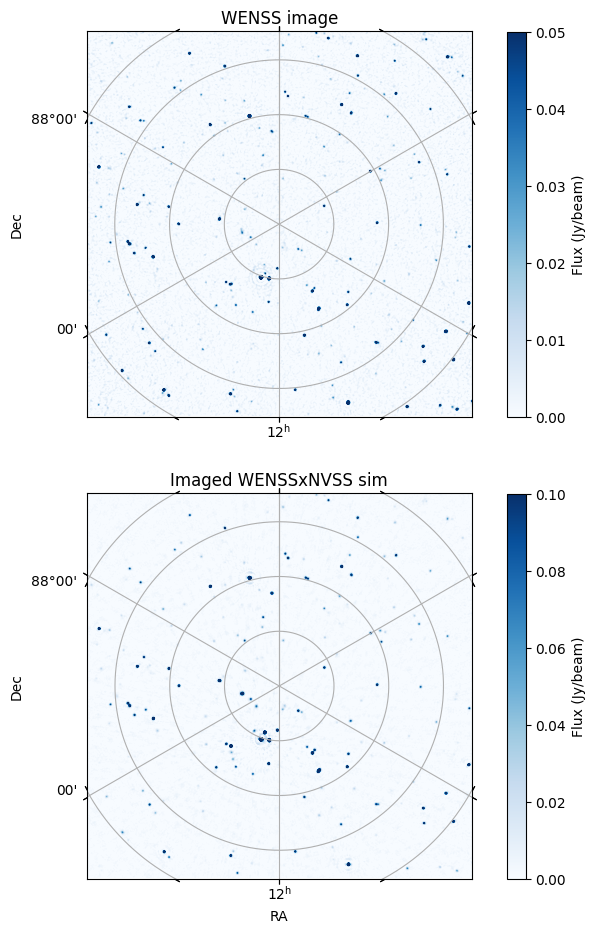

In [ ]:

fig = plt.figure(figsize=(9, 11))


vmax = 5e-2

ax1 = fig.add_subplot(211, projection=wcs_wenss)
im = ax1.imshow(data_wenss, origin='lower', cmap='Blues', vmin=0, vmax=vmax)

ax1.grid()



plt.colorbar(im, ax=ax1, label='Flux (Jy/beam)')
ax1.set_title('WENSS image')

with fits.open('woden_LBA-NCP-image.fits') as hdu:
    wcs_woden = WCS(hdu[0].header).celestial
    data_woden = np.squeeze(hdu[0].data)

ax2 = fig.add_subplot(212, projection=wcs_woden)


vmax=1e-1
im = ax2.imshow(data_woden, origin='lower', cmap='Blues', vmin=0, vmax=vmax)
plt.colorbar(im, ax=ax2, label='Flux (Jy/beam)')

ax2.grid()

ax2.set_title('Imaged WENSSxNVSS catalogue sim')

ax1.set_xlabel(' ')
ax1.set_ylabel('Dec')
ax1.set_xticklabels([])

ax2.set_xlabel('RA')
ax2.set_ylabel('Dec')


half_width=600
cent_x = 1024
cent_y = 1024

for ax in [ax1, ax2]:

    ax.set_xlim(cent_x - half_width, cent_x + half_width)
    ax.set_ylim(cent_y - half_width, cent_y + half_width)


# plt.tight_layout()
plt.show()

Righto, so the LBA primary beam is still in the image below, so the sources are dropping off at the edges. The units are different, because we have a different beam for LBA in the `Jy/Beam` units. Finally, the WENSS catalogue isn't perfect, and we did a lazy cross-match, so the sky model isn't perfect. But overall, this looks pretty good! 

## Do it all again, but with just NVSS
Out of interest, do we get better morphology if we just use the NVSS catalogue, and assume a spectral index of -0.8?

In [ ]:

unq_source_ids = np.array(crop_nvss['NVSS'], dtype='U32')
##order everything by source name to make adding component names easier
ras_nvss_full = crop_nvss['_RAJ2000'].data
decs_nvss_full = crop_nvss['_DEJ2000'].data

##use the gaussians from NVSS as it has better resolution
fluxes_1400 = crop_nvss['S1_4'].data/1000.0
majors = crop_nvss['MajAxis'].data/3600.0
minors = crop_nvss['MinAxis'].data/3600.0
pas = np.array(crop_nvss['PA'], dtype=np.float64)

pas[np.isnan(pas)] = 0.0

fluxes_extrap = fluxes_1400*(200.0/1400.0)**-0.8


num_comps = len(unq_source_ids)

unq_source_id_col = Column(unq_source_ids, name='UNQ_SOURCE_ID')

names = np.array([name+'_C000' for name in unq_source_ids], dtype='U32')
names_col = Column(names, name='NAME')

ras_col = Column(ras_nvss_full, name='RA', unit='deg')
decs_col = Column(decs_nvss_full, name='DEC', unit='deg')
fluxes_col = Column(fluxes_extrap, name='NORM_COMP_PL', unit='Jy')
si_col = Column(np.full_like(ras_nvss_full, -0.8), name='ALPHA_PL', unit='Jy')
majors_col = Column(majors, name='MAJOR_DC', unit='deg')
minors_col = Column(minors, name='MINOR_DC', unit='deg')
pas_col = Column(pas, name='PA_DC', unit='deg')

##Anything that has a major axis is a Gaussian, other make it a point source
comp_types = np.empty(unq_source_ids.shape, dtype='U3')
comp_types[majors == 0.0] = 'P'
comp_types[majors != 0.0] = 'G'

comp_types_col = Column(comp_types, name='COMP_TYPE')
##We're inputting everything as a power law
mod_types_col = Column(np.full(num_comps, 'pl'), name='MOD_TYPE')

cols = [unq_source_id_col, names_col,
        ras_col, decs_col, comp_types_col, mod_types_col,
        fluxes_col, si_col,
        majors_col, minors_col, pas_col]

new_table = Table(cols)
new_table.write('srclist_nvss_NCP.fits', overwrite=True)



In [232]:
%%bash

primary_beam="everybeam_LOFAR"
ra0=0.0
dec0=90.0
lofar_lat=52.905329712
lofar_long=6.867996528
date="2014-10-16T17:01:36.000"
ms_path=../../test_installation/everybeam/lba.MS

uvfits_name=woden_LBA-NCP_nvss
cat_name=srclist_nvss_NCP.fits
    
freq_reso=1e+6
low_freq=75e+6
num_freq_chans=20

time_res=3600.0
num_time_steps=24

run_woden.py \
    --ra0=${ra0} \
    --dec0=${dec0} \
    --latitude=${lofar_lat} \
    --longitude=${lofar_long} \
    --date=${date} \
    --output_uvfits_prepend=${uvfits_name} \
    --cat_filename=${cat_name} \
    --primary_beam=${primary_beam} \
    --lowest_channel_freq=${low_freq} \
    --freq_res=${freq_reso} \
    --num_freq_channels=${num_freq_chans} \
    --band_nums=1 \
    --time_res=${time_res} \
    --num_time_steps=${num_time_steps} \
    --beam_ms_path=${ms_path}

/home/jline/software/anaconda3/envs/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.3.0')


Successful readonly open of default-locked table ../../test_installation/everybeam/lba.MS/ANTENNA: 10 columns, 37 rows
You are using WODEN commit: No git describe nor __version__ avaible
LOADING IN /home/jline/software/WODEN_dev/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg 90.00000deg
Obs epoch initial LST was 294.9211333249 deg
Setting initial J2000 LST to 294.8284574349 deg
Setting initial mjd to 56946.7302777780
After precession initial latitude of the array is 52.8683555426 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1272 components
After cropping there are 1272 components
From Set 0 thread num 0 reading 0 points, 159 gauss, 0 shape, 0 shape coeffs using thread id 0
From Set 0 thread num 1 reading 0 points, 159 gauss, 0 shape, 0 shape coeffs using thread id 1
From Set 0 threa

In [233]:
make_ms('woden_LBA-NCP_nvss_band01.uvfits')

The telescope frame is set to '????', which generally indicates ignorance. Defaulting the frame to 'itrs', but this may lead to other warnings or errors.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 191664.7410455463 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 191664.7410455463 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
Writing in the MS file that the units of the data are uncalib, although some CASA process will ignore this and assume the units are all in Jy (or may not know how to handle data in these units).


In [234]:
%%bash

##YOU PROBABLY DON'T NEED THIS ENV VARIABLE
export OPENBLAS_NUM_THREADS=1

wsclean -name woden_LBA-NCP_nvss -niter 20000 \
   -size 2048 2048 -scale 0.0029296875 \
   -weight briggs 0 \
   -auto-threshold 0.5 -auto-mask 3 -pol I -multiscale \
   -j 12 -mgain 0.85 -no-update-model-required \
   -beam-size 56 \
   woden_LBA-NCP_nvss_band01.ms


WSClean version 3.0 (2021-08-26)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  75-95 (20)
Reordering woden_LBA-NCP_nvss_band01.ms into 1 x 1 parts.
Reordering: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
Initializing model visibilities: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
 == Constructing PSF ==
Precalculating weights for Briggs'(0) weighting...
Opening reordered part 0 spw 0 for woden_LBA-NCP_nvss_band01.ms
Detected 31.3 GB of system memory, usage not limited.
Opening reordered part 0 spw 0 for woden_LBA-NCP_nvss_band01.ms
Determining min and max w & theoretical beam size... DONE (w=[0.0061668:10286.7] lambdas, maxuvw=17187.2 lambda)
Theoretic beam = 12''
Small

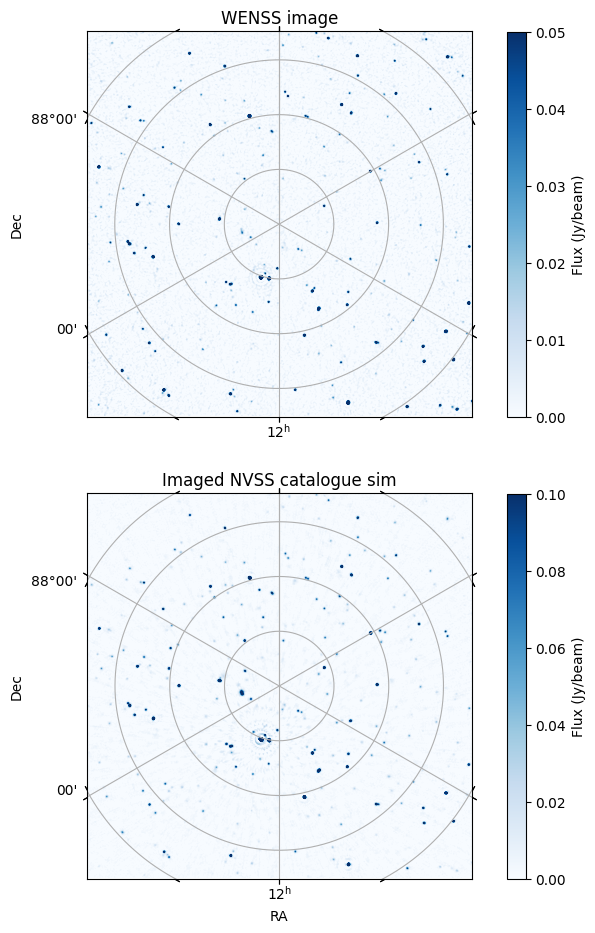

In [235]:

fig = plt.figure(figsize=(9, 11))

vmax = 5e-2

ax1 = fig.add_subplot(211, projection=wcs_wenss)
im = ax1.imshow(data_wenss, origin='lower', cmap='Blues', vmin=0, vmax=vmax)

ax1.grid()

plt.colorbar(im, ax=ax1, label='Flux (Jy/beam)')
ax1.set_title('WENSS image')

with fits.open('woden_LBA-NCP_nvss-image.fits') as hdu:
    wcs_woden = WCS(hdu[0].header).celestial
    data_woden = np.squeeze(hdu[0].data)

ax2 = fig.add_subplot(212, projection=wcs_woden)


vmax=1e-1
im = ax2.imshow(data_woden, origin='lower', cmap='Blues', vmin=0, vmax=vmax)
plt.colorbar(im, ax=ax2, label='Flux (Jy/beam)')

ax2.grid()

ax2.set_title('Imaged NVSS catalogue sim')

ax1.set_xlabel(' ')
ax1.set_ylabel('Dec')
ax1.set_xticklabels([])

ax2.set_xlabel('RA')
ax2.set_ylabel('Dec')


half_width=600
cent_x = 1024
cent_y = 1024

for ax in [ax1, ax2]:

    ax.set_xlim(cent_x - half_width, cent_x + half_width)
    ax.set_ylim(cent_y - half_width, cent_y + half_width)

# plt.tight_layout()
plt.show()

Huh so in terms of morphology, the NVSS sky model is better. Couple of spectral indexes are clearly off, where we have sources that are relatively too bright. But this just goes to highlight how difficult it is to make a good sky model.